# Compositional Cyber-Physical Systems Theory: Algebraic UAV

Author: Georgios Bakirtzis bakirtzis.net (bakirtzis@virginia.edu)

Projects in Julia are handled this way: `cd project` $\rightarrow$ `julia` $\rightarrow$ `]` $\rightarrow$ `activate .` $\rightarrow$ `add Catlab.jl`. This will create a `Project.toml` and a `Manifest.toml` which contains this information for other people to replicate how to run this notebook.

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations
#using LaTeXStrings

Sets up vizualization.

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
)

show_diagram (generic function with 1 method)

## Wiring diagram architecture

We first have to define our boxes, with what the inputs and outputs are, for example, the `sensor` box has two input `:e` and `:s` and one output `s_prime`.

In [3]:
s = Box(:sensor    , [:e, :s]      , [:s_prime])
c = Box(:controller, [:d, :s_prime], [:c])
d = Box(:dynamics  , [:c]          , [:s])

Box(:dynamics, [:c], [:s])

We then define the _architecture_ of our wiring diagram, meaning _vacant_ boxes and their interconnection without any notion of behavior.

In [4]:
# Diagram:           Inputs, Outputs <- Ports of entire diagram
UAV = WiringDiagram([:e,:d], [:s])

# Associate boxes to diagram
sensor     = add_box!(UAV, s)
controller = add_box!(UAV, c)
dynamics   = add_box!(UAV, d)

add_wires!(UAV, [
  # Net Inputs      
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  # Connections
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  # Net Outputs
  (dynamics,1) => (output_id(UAV),1)
])

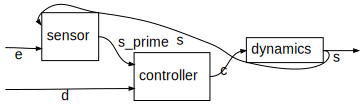

In [5]:
show_diagram(UAV)

The properties of the diagram can be accessed through certain functions:

In [6]:
nboxes(UAV)

3

In [7]:
nwires(UAV)

6

In [8]:
UAV

WiringDiagram([:e,:d], [:s], 
[ -2 => {inputs},
  -1 => {outputs},
  1 => Box(:sensor, [:e,:s], [:s_prime]),
  2 => Box(:controller, [:d,:s_prime], [:c]),
  3 => Box(:dynamics, [:c], [:s]) ],
[ Wire((-2,1) => (1,2)),
  Wire((-2,2) => (2,2)),
  Wire((1,1) => (2,1)),
  Wire((2,1) => (3,1)),
  Wire((3,1) => (1,1)),
  Wire((3,1) => (-1,1)) ])

This diagram is correct albeit poorly drawn by `graphviz` because it doesn't really understand cycles. This is okay we can always fix that for exposition purposes. The good thing is that we can evaluate our vacant blocks have the correct architecture visually.

## Wiring diagram behavior

Here we construct the fundamental functor of our work, namely a lax monoidal functor,
which using the architecture; that is, the vacant building blocks, can assign a particular behavior
in the form of:
$F: \text{syntax} \rightarrow \text{semantics}$.

Unfortunately $F$ here is a *lax* monoidal functor, which means that it behaves "up-to-isomorphism". This might mean there is a problem with composition, $g\circ f$, being of the following form $$eq(f)\times eq(g)\subset eq(f\circ g)$$ or... not! We will find out.

The semantics were defined using the equations found in this example: [Aircraft Pitch: System Modeling](https://ctms.engin.umich.edu/CTMS/index.php?example=AircraftPitch&section=SystemModeling)  

![Cat](https://ctms.engin.umich.edu/CTMS/Content/AircraftPitch/System/Modeling/figures/flightdynamics.png)

We require a set of coefficients to define the behavior of the controller box and the sensor box. As there is one state per box, one can see each box as a 1rst order filter. For simplicity, let us assume the behavior is _stable_ and that it takes the form of a _low pass filter_. See:  

- [First order low-pass filter](http://www.controlsystemsacademy.com/0020/0020.html)
- [Simple high-pass, band-pass, and band-stop filter](https://www.norwegiancreations.com/2016/03/arduino-tutorial-simple-high-pass-band-pass-and-band-stop-filtering/)

In [16]:
function semantics(diagram)
    # State functions: 
    equation_sensor(u, x, p, t)  = [ -p.λs*(u[1] - x[1] - x[2]) ];        # x = [θ, e] -> [Pitch angle, pitch offset]

    equation_control(u, x, p, t) = [ -p.λc*(u[1] + p.kθ*x[1] - x[2]) ];   # x = [Sl, d] -> [sensor output, control input]
    
    equation_dynamic(u, x, p, t) = [ -0.313*u[1] +  56.7*u[2] +  0.232*x[1],    # α -> Angle of attack
                                    -0.0139*u[1] - 0.426*u[2] + 0.0203*x[1],    # q -> Angular velocity
                                                    56.7*u[2]              ];   # θ -> Pitch angle    
                                                                          # x = [Sc] -> Controller output 
    # Readout functions:  [select specific state]
    readout_sensor(u, p, t)  = [ u[1] ];  # sl
    readout_control(u, p, t) = [ u[1] ];  # sc
    readout_dynamic(u, p, t) = [ u[3] ];  # θ
    
    # Machines for each box in diagram:
                                  # Inputs, States, Outputs
    s_machine = ContinuousMachine{Float64}( 2, 1, 1, equation_sensor , readout_sensor );
    c_machine = ContinuousMachine{Float64}( 2, 1, 1, equation_control, readout_control ); 
    d_machine = ContinuousMachine{Float64}( 1, 3, 1, equation_dynamic, readout_dynamic ); 
    
    # Output composition
    return oapply( diagram, 
                   Dict(:sensor     => s_machine, 
                        :controller => c_machine,
                        :dynamics   => d_machine) );
end

semantics (generic function with 1 method)

AlgebraicDynamics allows us to associate user defined equations to a wiring diagram.

In [17]:
comp = semantics(UAV)

ContinuousMachine(ℝ^5 × ℝ^2 → ℝ^5)

With the composed continuousMachine it is possible solve the resulting system of ODE's. 
  
**Note**: ODEproblem does not appear to follow the inputs mentioned in the link below. While the documention mentions xs, and u0 as the inputs, the actual behavior appears to be reversed. u0 preceeds xs.

https://algebraicjulia.github.io/AlgebraicDynamics.jl/dev/api/  

To investigate the effects of the sensor and control coefficients, It is useful to define an additional function that displays the solution of the system.

In [23]:
function plotSol(sol)
    fsize = 14
    # Display solution
    plot( sol.t,                                                   # X values
        [ sol[1,:], sol[2,:], sol[3,:], 1e2*sol[4,:], sol[5,:] ],  # Y values [q is amplified]
        label  = ["sl" "sc" "α" "q" "θ"], 
        xlabel = "time paramter - t", 
        ylabel = "response",
        title  = "Aircraft Pitch behaviour",
        size   = (1000,700),
        # Font size:
        legendfontsize = fsize,
        xtickfontsize  = fsize,
        ytickfontsize  = fsize,
        xguidefontsize = fsize,
        yguidefontsize = fsize,
        titlefontsize  = fsize,
        lw = 4,
        # Margins:
        left_margin   = 15Plots.mm,
        bottom_margin = 15Plots.mm );
end

plotSol (generic function with 2 methods)

By choosing a set of constant initial conditions the behavior of the system can be explored.

In [24]:
# Initial values
x_init = [0.01, 0.05];          # Inputs: [e, d] -> [θ offset, 𝛿 control input]
u_init = [0, 0, 0, 0, 0];       # States: [sl, sc, α, q, θ]

# Integration interval
t_span = (0, 20); 

# Parameters:
param = (λs = 100, # Decay constant of sensor
         λc = 100, # Decay constant of controller
         kθ = 0)   # Gain of control input proportional to sensor output. Causes a feedback loop.

(λs = 100, λc = 100, kθ = 0)

In [25]:
# Function to solve ODE's
function solveSystem()
    return solve( ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] );
end

solveSystem (generic function with 1 method)

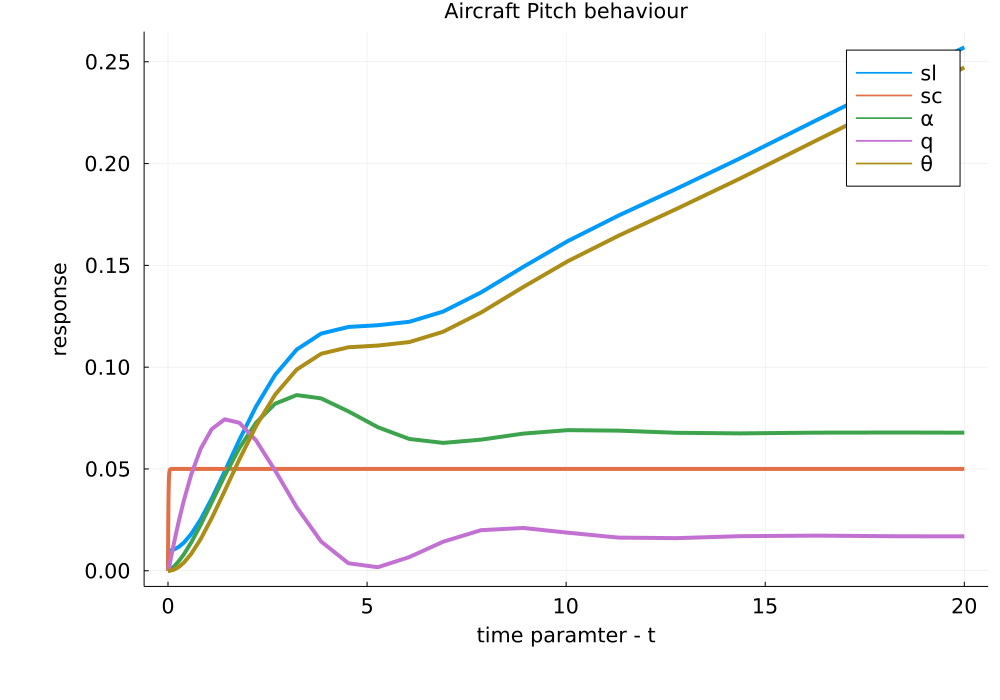

In [26]:
# Solve and display ODEs
plotSol( solveSystem() )

Let us see what happens when the coefficients of the sensor and controller box are modified.  

Increasing _gain_θ_ causes the sensor to induce a control input. Depending on the sign, This correction can increase or decrease the stability of the system. One can interpret this as the sensor outputing an estimate of the pitch angle of the aircraft, and the controller using this measurement to deflect the elevator. 

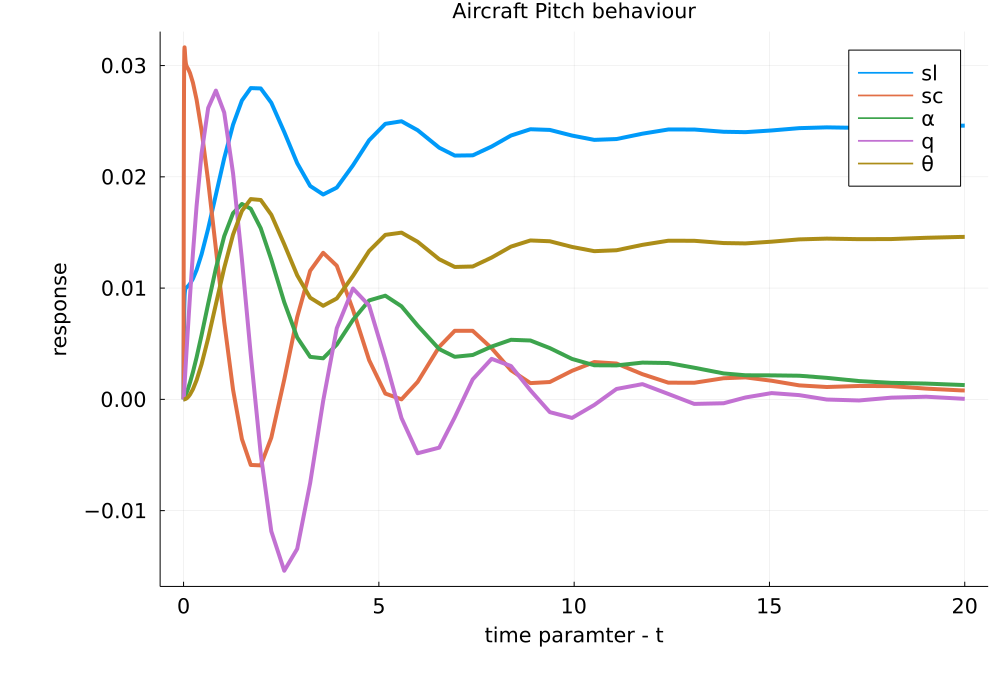

In [28]:
# Parameters:
param = (λs = 100, 
         λc = 100, 
         kθ = 2)   # stable correction gain

# Solve and plot:
plotSol( solveSystem() )

A negative _gain_θ_ induces instability and causes system's behavior to grow exponentially.

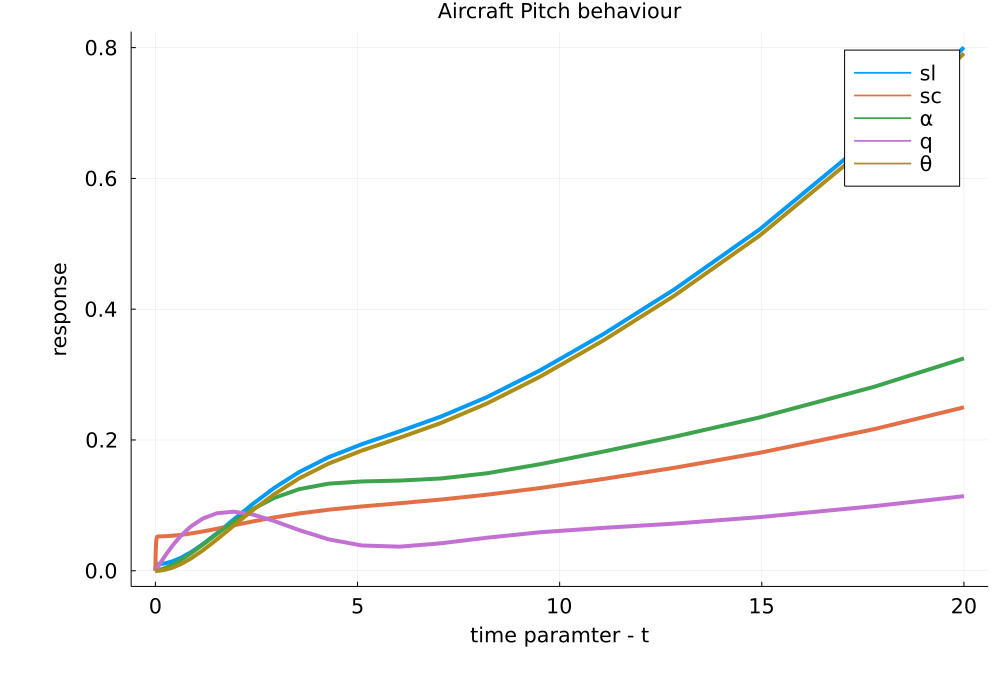

In [29]:
# Parameters:  
param = (λs = 100, 
         λc = 100, 
         kθ = -0.25)   # untable correction gain

# Solve and plot:
plotSol( solveSystem() )

By contrast, changing the reponse of the sensor and controller modifies the delay of the low pass filters. This is most obvious if the sensor responds quickly and the controller has a large delay.

If one wants to output the input of a box, a very large response is required as this creates an effective all-pass filter. That is, a low pass filter with an extremely large cuttoff frequency will pass almost any signal.

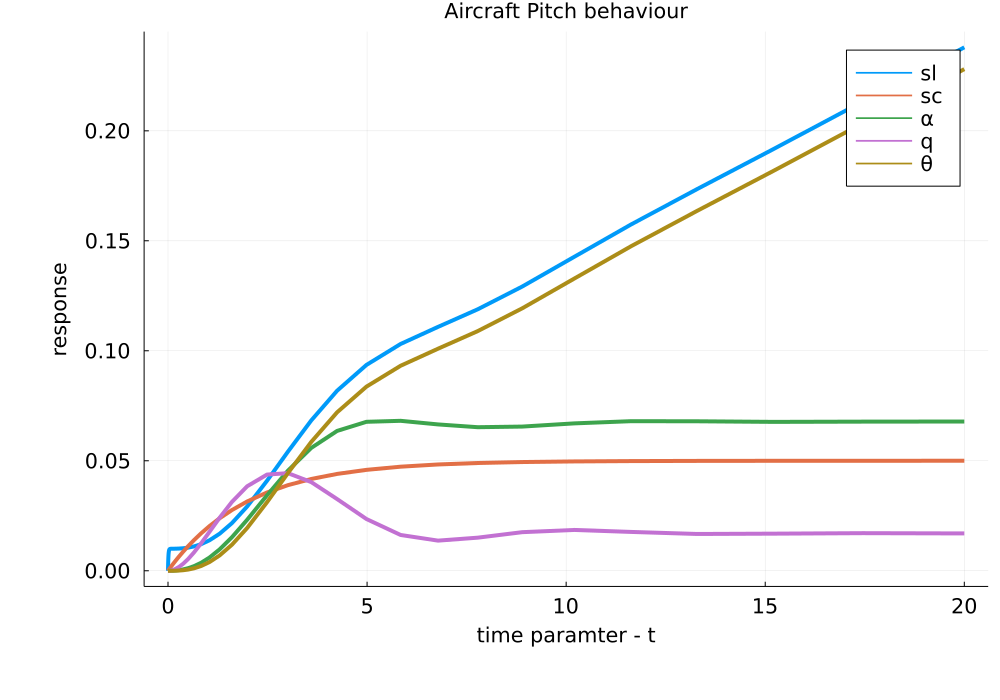

In [30]:
# Parameters:  
param = (λs = 100, # Response of sensor:  
         λc = 0.5, # Response of controller
         kθ = 0)   # no feedback

# Solve and plot:
plotSol( solveSystem() )